In [2]:
# Imports and environment checks
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

try:
    import cv2
except Exception:
    cv2 = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True


print("numpy:", np.__version__)
print("pandas:", pd.__version__)



numpy: 2.3.3
pandas: 2.2.3


In [3]:
# Config: paths and constants
REPO_ROOT = Path.cwd()
DATA_ROOT = REPO_ROOT / "Nutrition5K" / "Nutrition5K"
TRAIN_DIR_COLOR = DATA_ROOT / "train" / "color"
TRAIN_DIR_DEPTH_COLOR = DATA_ROOT / "train" / "depth_color"
TRAIN_DIR_DEPTH_RAW = DATA_ROOT / "train" / "depth_raw"
TEST_DIR_COLOR = DATA_ROOT / "test" / "color"
TEST_DIR_DEPTH_COLOR = DATA_ROOT / "test" / "depth_color"
TEST_DIR_DEPTH_RAW = DATA_ROOT / "test" / "depth_raw"

SAMPLE_SUBMISSION = REPO_ROOT / "sample_submission.csv"
TRAIN_META_CANDIDATES = [
    DATA_ROOT / "nutrition5k_train.csv",
    REPO_ROOT / "Nutrition5K" / "nutrition5k_train.csv",
]

TARGET_COL = "Value"
ID_COL = "ID"

print("REPO_ROOT:", REPO_ROOT)
print("DATA_ROOT exists:", DATA_ROOT.exists())
print("Color train dir exists:", TRAIN_DIR_COLOR.exists())
print("Sample submission exists:", SAMPLE_SUBMISSION.exists())
print("Any train meta exists:", any(p.exists() for p in TRAIN_META_CANDIDATES))



REPO_ROOT: d:\GitHub\CV_PRJ
DATA_ROOT exists: True
Color train dir exists: True
Sample submission exists: True
Any train meta exists: True


In [4]:
# Load training metadata
train_meta_path = None
for p in TRAIN_META_CANDIDATES:
    if p.exists():
        train_meta_path = p
        break

if train_meta_path is None:
    print("[WARN] No train metadata found; creating a tiny synthetic example.")
    demo_ids = ["dish_0000", "dish_0001", "dish_0002", "dish_0003", "dish_0004"]
    train_df = pd.DataFrame({ID_COL: demo_ids, TARGET_COL: np.random.uniform(50, 500, size=len(demo_ids))})
else:
    train_df = pd.read_csv(train_meta_path)

print("train_df shape:", train_df.shape)
print(train_df.head())



train_df shape: (3301, 2)
          ID       Value
0  dish_0000  221.167068
1  dish_0001  140.980011
2  dish_0002  274.335999
3  dish_0003  589.501648
4  dish_0004  258.599670


In [5]:
# IO helpers

def read_color_image(sample_dir: Path):
    pngs = sorted(list(sample_dir.rglob("*.png")))
    if not pngs:
        return None
    return np.asarray(Image.open(pngs[0]).convert("RGB"))


def get_dish_dir(split: str, dish_id: str) -> Path:
    return (DATA_ROOT / split / "color" / dish_id)



## Above are pre processing

chosen sample ids: ['dish_3301', 'dish_3302']


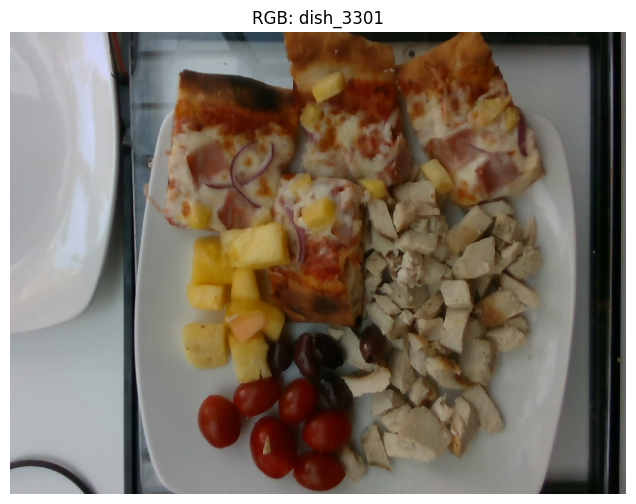

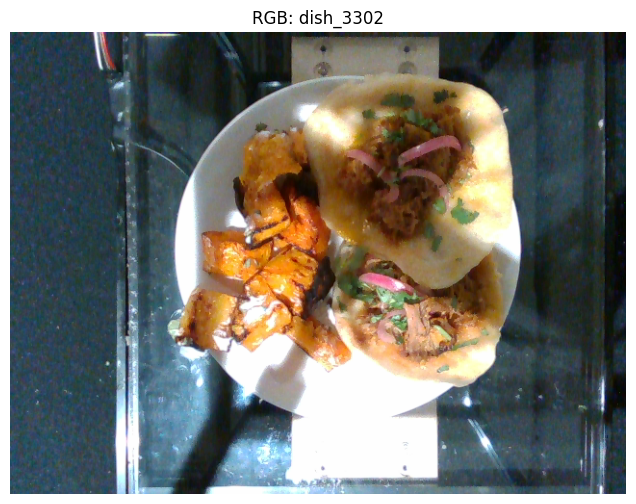

In [6]:
# Visualize samples (RGB)
sample_ids = []
if TEST_DIR_COLOR.exists() and SAMPLE_SUBMISSION.exists():
    sub_df = pd.read_csv(SAMPLE_SUBMISSION)
    sample_ids = list(sub_df[ID_COL].head(2))
elif TRAIN_DIR_COLOR.exists() and ID_COL in train_df.columns:
    sample_ids = list(train_df[ID_COL].head(2))

print("chosen sample ids:", sample_ids)

for dish_id in sample_ids:
    split = "test" if (TEST_DIR_COLOR / dish_id).exists() else "train"
    color_dir = get_dish_dir(split, dish_id)
    rgb = read_color_image(color_dir)
    if rgb is None:
        print("skip", dish_id, "(no image)")
        continue
    plt.imshow(rgb)
    plt.title(f"RGB: {dish_id}")
    plt.axis("off")
    plt.show()



In [ ]:
# Simple RGB histogram features

def compute_color_histogram(img: np.ndarray, num_bins: int = 16) -> np.ndarray:
    if img is None:
        return np.zeros(num_bins * 3, dtype=np.float32)
    feats = []
    for c in range(3):
        hist, _ = np.histogram(img[..., c], bins=num_bins, range=(0, 255), density=True)
        feats.append(hist)
    return np.concatenate(feats).astype(np.float32)


def build_features_for_id(dish_id: str, split: str = "train") -> np.ndarray:
    rgb = read_color_image(get_dish_dir(split, dish_id))
    return compute_color_histogram(rgb)



In [ ]:
# Build train/val, train baseline, report metrics
X_list, y_list, used_ids = [], [], []

if {ID_COL, TARGET_COL}.issubset(train_df.columns):
    for row in train_df[[ID_COL, TARGET_COL]].itertuples(index=False):
        dish_id, target = row
        try:
            feats = build_features_for_id(dish_id, split="train")
        except Exception:
            feats = np.zeros(48, dtype=np.float32)
        X_list.append(feats)
        y_list.append(float(target))
        used_ids.append(dish_id)
else:
    # Fallback minimal set
    used_ids = [f"dish_{i:04d}" for i in range(8)]
    X_list = [np.zeros(48, dtype=np.float32) for _ in used_ids]
    y_list = list(np.random.uniform(100, 400, size=len(used_ids)))

X = np.vstack(X_list) if len(X_list) else np.zeros((0, 48), dtype=np.float32)
y = np.array(y_list, dtype=np.float32)

if len(y) >= 4:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    X_train, X_val, y_train, y_val = X, X, y, y

model = Ridge(alpha=1.0, random_state=42)
model.fit(X_train, y_train)

pred_val = model.predict(X_val) if len(y_val) else np.array([])
mse_val = mean_squared_error(y_val, pred_val) if len(y_val) else float("nan")
print("Validation MSE:", mse_val)



## Deep Learning Model (PyTorch + Custom CNN)

Build CNN regression model from scratch without pretrained weights.




In [9]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("PyTorch version:", torch.__version__)

# GPU info
if torch.cuda.is_available():
    print(f"GPU Count: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("No GPU available, using CPU")



Device: cuda
PyTorch version: 2.5.1+cu121
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 4070 SUPER
GPU Memory: 11.99 GB


In [15]:
# Dataset for PyTorch
class DishDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dish_id = row[ID_COL]
        dish_dir = self.root_dir / dish_id
        
        pngs = sorted(list(dish_dir.rglob("*.png")))
        if len(pngs) == 0:
            img = Image.new("RGB", (224, 224), color=(128, 128, 128))
        else:
            img = Image.open(pngs[0]).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        if self.is_test:
            return img, dish_id
        else:
            target = torch.tensor(row[TARGET_COL], dtype=torch.float32)
            return img, target



In [16]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [17]:
# Train/val split
from sklearn.model_selection import train_test_split as sk_split
train_df_split, val_df_split = sk_split(train_df, test_size=0.15, random_state=42)

print("Train set:", len(train_df_split))
print("Val set:", len(val_df_split))

train_dataset = DishDataset(train_df_split, TRAIN_DIR_COLOR, transform=train_transform)
val_dataset = DishDataset(val_df_split, TRAIN_DIR_COLOR, transform=val_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)



Train set: 2805
Val set: 496


In [ ]:
# Model: Custom CNN (trained from scratch)
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extractor
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Regression head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.squeeze()

model_dl = CustomCNN().to(device)
print("Custom CNN model loaded on", device)



Custom CNN model loaded on cuda


In [26]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model_dl.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

EPOCHS = 50



In [27]:
# Training loop with progress bars
from tqdm import tqdm

for epoch in range(EPOCHS):
    model_dl.train()
    train_loss = 0.0
    
    # Training with progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for imgs, targets in train_pbar:
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
        preds = model_dl(imgs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        
        # Update progress bar with current loss
        train_pbar.set_postfix({'Loss': f'{loss.item():.2f}'})
    
    train_loss /= len(train_dataset)
    
    # Validation with progress bar
    model_dl.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for imgs, targets in val_pbar:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model_dl(imgs)
            loss = criterion(preds, targets)
            val_loss += loss.item() * imgs.size(0)
            
            # Update progress bar with current loss
            val_pbar.set_postfix({'Loss': f'{loss.item():.2f}'})
    
    val_loss /= len(val_dataset)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.2f} | Val Loss: {val_loss:.2f}")



Epoch 1/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Loss=5750.63] 


Epoch 1/50 | Train Loss: 32963.82 | Val Loss: 23585.13


Epoch 2/50 [Val]: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s, Loss=20459.35]


Epoch 2/50 | Train Loss: 26711.73 | Val Loss: 34608.92


Epoch 3/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s, Loss=24066.21] 


Epoch 3/50 | Train Loss: 25462.43 | Val Loss: 48614.72


Epoch 4/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Loss=10213.03]


Epoch 4/50 | Train Loss: 25328.96 | Val Loss: 22849.49


Epoch 5/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s, Loss=12683.33]


Epoch 5/50 | Train Loss: 23172.16 | Val Loss: 20349.11


Epoch 6/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Loss=7315.82] 


Epoch 6/50 | Train Loss: 22093.97 | Val Loss: 18042.58


Epoch 7/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=5683.79] 


Epoch 7/50 | Train Loss: 22218.90 | Val Loss: 19522.88


Epoch 8/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, Loss=11548.27]


Epoch 8/50 | Train Loss: 21447.27 | Val Loss: 22134.33


Epoch 9/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Loss=5786.04] 


Epoch 9/50 | Train Loss: 21669.01 | Val Loss: 20542.66


Epoch 10/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, Loss=11456.72]


Epoch 10/50 | Train Loss: 20407.87 | Val Loss: 23199.20


Epoch 11/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Loss=5748.10] 


Epoch 11/50 | Train Loss: 20519.33 | Val Loss: 14909.22


Epoch 12/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s, Loss=5520.04] 


Epoch 12/50 | Train Loss: 19382.88 | Val Loss: 16259.25


Epoch 13/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=5078.50] 


Epoch 13/50 | Train Loss: 19708.30 | Val Loss: 16360.99


Epoch 14/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=6786.46] 


Epoch 14/50 | Train Loss: 19473.03 | Val Loss: 17929.25


Epoch 15/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Loss=5175.92] 


Epoch 15/50 | Train Loss: 18904.89 | Val Loss: 14830.08


Epoch 16/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, Loss=21244.08]


Epoch 16/50 | Train Loss: 19103.84 | Val Loss: 34796.64


Epoch 17/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, Loss=7579.56] 


Epoch 17/50 | Train Loss: 18853.08 | Val Loss: 14580.11


Epoch 18/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s, Loss=4704.82] 


Epoch 18/50 | Train Loss: 17899.23 | Val Loss: 14896.64


Epoch 19/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, Loss=8987.01] 


Epoch 19/50 | Train Loss: 18400.31 | Val Loss: 14547.01


Epoch 20/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, Loss=5862.41] 


Epoch 20/50 | Train Loss: 18166.23 | Val Loss: 13420.94


Epoch 21/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=6437.71] 


Epoch 21/50 | Train Loss: 17747.22 | Val Loss: 13705.78


Epoch 22/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s, Loss=7688.49] 


Epoch 22/50 | Train Loss: 17708.75 | Val Loss: 13699.55


Epoch 23/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s, Loss=15320.20]


Epoch 23/50 | Train Loss: 17386.76 | Val Loss: 22613.15


Epoch 24/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, Loss=4137.98] 


Epoch 24/50 | Train Loss: 17538.48 | Val Loss: 14020.04


Epoch 25/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s, Loss=4365.85] 


Epoch 25/50 | Train Loss: 17036.90 | Val Loss: 13595.57


Epoch 26/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s, Loss=6595.66] 


Epoch 26/50 | Train Loss: 16588.72 | Val Loss: 12840.90


Epoch 27/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s, Loss=6851.76] 


Epoch 27/50 | Train Loss: 17123.67 | Val Loss: 13238.43


Epoch 28/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, Loss=4545.69] 


Epoch 28/50 | Train Loss: 16533.94 | Val Loss: 13124.08


Epoch 29/50 [Val]: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s, Loss=4581.59] 


Epoch 29/50 | Train Loss: 17238.55 | Val Loss: 12867.54


Epoch 30/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s, Loss=5367.25] 


Epoch 30/50 | Train Loss: 16046.86 | Val Loss: 12405.52


Epoch 31/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s, Loss=5750.42] 


Epoch 31/50 | Train Loss: 15576.51 | Val Loss: 12661.66


Epoch 32/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Loss=4996.55] 


Epoch 32/50 | Train Loss: 16409.98 | Val Loss: 12291.39


Epoch 33/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=8795.02] 


Epoch 33/50 | Train Loss: 16315.30 | Val Loss: 13520.08


Epoch 34/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, Loss=5227.83] 


Epoch 34/50 | Train Loss: 15775.06 | Val Loss: 12666.38


Epoch 35/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=3845.34] 


Epoch 35/50 | Train Loss: 15937.57 | Val Loss: 13740.68


Epoch 36/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s, Loss=5323.73] 


Epoch 36/50 | Train Loss: 16491.34 | Val Loss: 12011.96


Epoch 37/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=4679.41] 


Epoch 37/50 | Train Loss: 15845.99 | Val Loss: 12121.11


Epoch 38/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Loss=5481.65] 


Epoch 38/50 | Train Loss: 15536.72 | Val Loss: 12165.65


Epoch 39/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=5339.06] 


Epoch 39/50 | Train Loss: 15541.76 | Val Loss: 12300.61


Epoch 40/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, Loss=5911.41] 


Epoch 40/50 | Train Loss: 15564.99 | Val Loss: 12116.60


Epoch 41/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s, Loss=5258.17] 


Epoch 41/50 | Train Loss: 15989.29 | Val Loss: 12137.89


Epoch 42/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, Loss=5034.30] 


Epoch 42/50 | Train Loss: 15824.25 | Val Loss: 11939.74


Epoch 43/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=5455.97] 


Epoch 43/50 | Train Loss: 15938.73 | Val Loss: 12015.47


Epoch 44/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=5187.41] 


Epoch 44/50 | Train Loss: 15903.34 | Val Loss: 12102.34


Epoch 45/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s, Loss=4562.88] 


Epoch 45/50 | Train Loss: 15626.68 | Val Loss: 12889.69


Epoch 46/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Loss=5075.18] 


Epoch 46/50 | Train Loss: 15430.26 | Val Loss: 11924.31


Epoch 47/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Loss=5018.92] 


Epoch 47/50 | Train Loss: 15472.06 | Val Loss: 12135.66


Epoch 48/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, Loss=4973.35] 


Epoch 48/50 | Train Loss: 15599.38 | Val Loss: 11978.13


Epoch 49/50 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s, Loss=5804.16] 


Epoch 49/50 | Train Loss: 15665.23 | Val Loss: 11882.66


Epoch 50/50 [Val]: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s, Loss=5307.43] 

Epoch 50/50 | Train Loss: 15384.02 | Val Loss: 11977.59


In [ ]:
# Generate test predictions
# Use ALL test samples, not just the sample_submission.csv
test_ids = [p.name for p in sorted(TEST_DIR_COLOR.iterdir()) if p.is_dir()]
test_df = pd.DataFrame({ID_COL: test_ids})

print(f"Found {len(test_df)} test samples")
print(f"Test samples range: {test_df[ID_COL].min()} to {test_df[ID_COL].max()}")

test_dataset = DishDataset(test_df, TEST_DIR_COLOR, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model_dl.eval()
predictions = []
dish_ids_test = []

with torch.no_grad():
    for imgs, ids in test_loader:
        imgs = imgs.to(device)
        preds = model_dl(imgs)
        predictions.extend(preds.cpu().numpy().tolist())
        dish_ids_test.extend(ids)

submission_dl = pd.DataFrame({ID_COL: dish_ids_test, TARGET_COL: predictions})
submission_dl.to_csv(REPO_ROOT / "submission_custom_cnn.csv", index=False)
print("Saved: submission_custom_cnn.csv")
print(submission_dl.head())



In [28]:
# SE (Squeeze-and-Excitation) Block for channel attention
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

print("SEBlock defined")


SEBlock defined


In [29]:
# Residual Block with SE attention
class ResidualBlockSE(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        
        out += identity
        out = self.relu(out)
        
        return out

print("ResidualBlockSE defined")


ResidualBlockSE defined


In [30]:
# Improved CNN with Residual blocks and SE attention
class ImprovedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers with SE attention
        self.layer1 = nn.Sequential(
            ResidualBlockSE(64, 128, stride=2),
            ResidualBlockSE(128, 128, stride=1)
        )
        
        self.layer2 = nn.Sequential(
            ResidualBlockSE(128, 256, stride=2),
            ResidualBlockSE(256, 256, stride=1)
        )
        
        self.layer3 = nn.Sequential(
            ResidualBlockSE(256, 512, stride=2),
            ResidualBlockSE(512, 512, stride=1)
        )
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Regression head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x.squeeze()

# Create improved model
model_improved = ImprovedCNN().to(device)
print("Improved CNN model created on", device)
print(f"Model parameters: {sum(p.numel() for p in model_improved.parameters()):,}")


Improved CNN model created on cuda
Model parameters: 11,278,913


In [31]:
# Training setup for improved model
criterion_improved = nn.MSELoss()
optimizer_improved = optim.AdamW(model_improved.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_improved = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_improved, T_0=10, T_mult=2)

EPOCHS_IMPROVED = 60

# Track training history
train_losses = []
val_losses = []

print("Training setup complete")


Training setup complete


In [33]:
# Training loop for improved model
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(EPOCHS_IMPROVED):
    # Training phase
    model_improved.train()
    train_loss = 0.0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS_IMPROVED} [Train]")
    for imgs, targets in train_pbar:
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer_improved.zero_grad()
        preds = model_improved(imgs)
        loss = criterion_improved(preds, targets)
        loss.backward()
        optimizer_improved.step()
        train_loss += loss.item() * imgs.size(0)
        train_pbar.set_postfix({'Loss': f'{loss.item():.2f}'})
    
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model_improved.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS_IMPROVED} [Val]")
        for imgs, targets in val_pbar:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model_improved(imgs)
            loss = criterion_improved(preds, targets)
            val_loss += loss.item() * imgs.size(0)
            val_pbar.set_postfix({'Loss': f'{loss.item():.2f}'})
    
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    
    # Update scheduler
    scheduler_improved.step()
    current_lr = optimizer_improved.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{EPOCHS_IMPROVED} | Train Loss: {train_loss:.2f} | Val Loss: {val_loss:.2f} | LR: {current_lr:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model_improved.state_dict(), 'best_improved_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model_improved.load_state_dict(torch.load('best_improved_model.pth'))
print(f"\nBest validation loss: {best_val_loss:.2f}")


Epoch 1/60 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, Loss=19925.15]


Epoch 1/60 | Train Loss: 28505.53 | Val Loss: 31665.55 | LR: 0.000976


Epoch 2/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s, Loss=11210.83]


Epoch 2/60 | Train Loss: 25183.39 | Val Loss: 26898.21 | LR: 0.000905


Epoch 3/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=98466.19] 


Epoch 3/60 | Train Loss: 21995.47 | Val Loss: 105109.53 | LR: 0.000794


Epoch 4/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=4667.85] 


Epoch 4/60 | Train Loss: 22903.06 | Val Loss: 15827.96 | LR: 0.000655


Epoch 5/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s, Loss=7254.40] 


Epoch 5/60 | Train Loss: 21096.15 | Val Loss: 22604.37 | LR: 0.000500


Epoch 6/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s, Loss=4325.15] 


Epoch 6/60 | Train Loss: 19063.09 | Val Loss: 14298.83 | LR: 0.000345


Epoch 7/60 [Val]: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s, Loss=10482.38]


Epoch 7/60 | Train Loss: 18439.92 | Val Loss: 16354.79 | LR: 0.000206


Epoch 8/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s, Loss=8810.23] 


Epoch 8/60 | Train Loss: 17380.57 | Val Loss: 12675.43 | LR: 0.000095


Epoch 9/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s, Loss=7111.66] 


Epoch 9/60 | Train Loss: 16378.50 | Val Loss: 15287.34 | LR: 0.000024


Epoch 10/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.50it/s, Loss=7853.61] 


Epoch 10/60 | Train Loss: 15932.04 | Val Loss: 11816.40 | LR: 0.001000


Epoch 11/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=12191.88]


Epoch 11/60 | Train Loss: 20582.92 | Val Loss: 27787.58 | LR: 0.000994


Epoch 12/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=12711.71]


Epoch 12/60 | Train Loss: 19936.24 | Val Loss: 21852.01 | LR: 0.000976


Epoch 13/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s, Loss=6440.81] 


Epoch 13/60 | Train Loss: 19265.93 | Val Loss: 15058.45 | LR: 0.000946


Epoch 14/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, Loss=18022.50]


Epoch 14/60 | Train Loss: 17691.36 | Val Loss: 16348.59 | LR: 0.000905


Epoch 15/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s, Loss=16238.41]


Epoch 15/60 | Train Loss: 18317.83 | Val Loss: 15963.84 | LR: 0.000854


Epoch 16/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, Loss=12010.59]


Epoch 16/60 | Train Loss: 16549.33 | Val Loss: 23768.70 | LR: 0.000794


Epoch 17/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, Loss=13161.79]


Epoch 17/60 | Train Loss: 17035.32 | Val Loss: 12677.50 | LR: 0.000727


Epoch 18/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s, Loss=7434.56] 


Epoch 18/60 | Train Loss: 15638.49 | Val Loss: 12245.18 | LR: 0.000655


Epoch 19/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s, Loss=10404.56]


Epoch 19/60 | Train Loss: 14802.33 | Val Loss: 12609.07 | LR: 0.000578


Epoch 20/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s, Loss=9271.66] 


Epoch 20/60 | Train Loss: 14190.25 | Val Loss: 11620.30 | LR: 0.000500


Epoch 21/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, Loss=9756.84] 


Epoch 21/60 | Train Loss: 13142.59 | Val Loss: 12167.33 | LR: 0.000422


Epoch 22/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s, Loss=11586.92]


Epoch 22/60 | Train Loss: 11290.77 | Val Loss: 15079.77 | LR: 0.000345


Epoch 23/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, Loss=9443.59] 


Epoch 23/60 | Train Loss: 12336.69 | Val Loss: 11526.68 | LR: 0.000273


Epoch 24/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s, Loss=7489.21] 


Epoch 24/60 | Train Loss: 11710.32 | Val Loss: 10930.52 | LR: 0.000206


Epoch 25/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s, Loss=6772.44] 


Epoch 25/60 | Train Loss: 9690.60 | Val Loss: 9893.53 | LR: 0.000146


Epoch 26/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, Loss=8626.32] 


Epoch 26/60 | Train Loss: 8472.50 | Val Loss: 10373.21 | LR: 0.000095


Epoch 27/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, Loss=7445.81] 


Epoch 27/60 | Train Loss: 8108.75 | Val Loss: 10523.57 | LR: 0.000054


Epoch 28/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s, Loss=7577.67] 


Epoch 28/60 | Train Loss: 7302.67 | Val Loss: 10297.31 | LR: 0.000024


Epoch 29/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s, Loss=7366.54] 


Epoch 29/60 | Train Loss: 6853.59 | Val Loss: 9935.30 | LR: 0.000006


Epoch 30/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s, Loss=7440.31] 


Epoch 30/60 | Train Loss: 6256.14 | Val Loss: 10146.08 | LR: 0.001000


Epoch 31/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.67it/s, Loss=9292.19] 


Epoch 31/60 | Train Loss: 13828.11 | Val Loss: 12599.90 | LR: 0.000998


Epoch 32/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=9191.18] 


Epoch 32/60 | Train Loss: 14253.03 | Val Loss: 14192.92 | LR: 0.000994


Epoch 33/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Loss=11174.39]


Epoch 33/60 | Train Loss: 15262.52 | Val Loss: 15990.12 | LR: 0.000986


Epoch 34/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s, Loss=6198.51] 


Epoch 34/60 | Train Loss: 15394.10 | Val Loss: 11785.79 | LR: 0.000976


Epoch 35/60 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s, Loss=8614.56] 

Epoch 35/60 | Train Loss: 14556.08 | Val Loss: 12535.33 | LR: 0.000962
Early stopping at epoch 35

Best validation loss: 9893.53



C:\Users\Tom\AppData\Local\Temp\ipykernel_15964\2987381064.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_improved.load_state_dict(torch.load('best_improved_mod

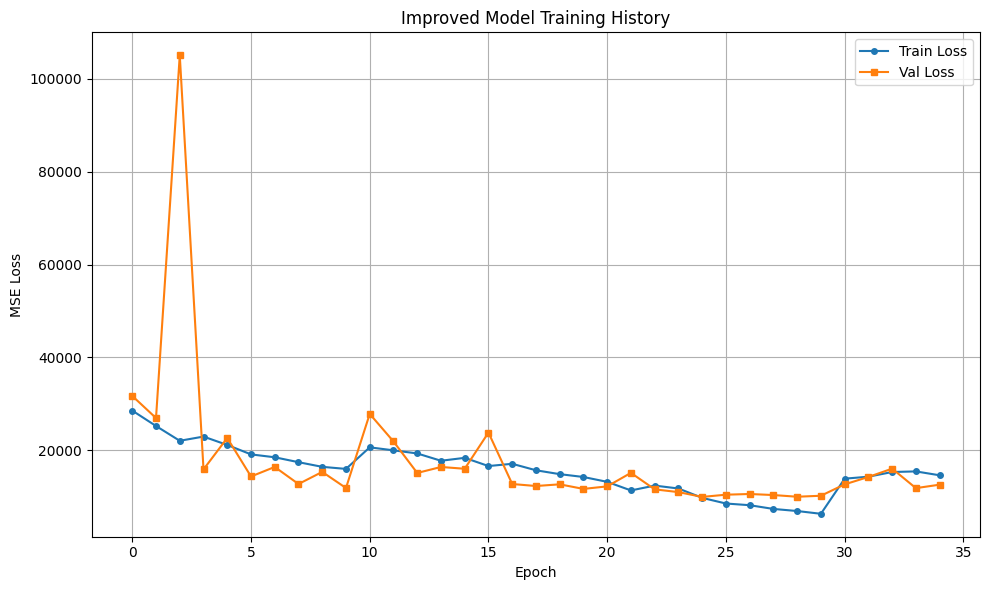

Final Train Loss: 14556.08
Best Val Loss: 9893.53


In [34]:
# Plot training history
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_losses, label='Train Loss', marker='o', markersize=4)
ax.plot(val_losses, label='Val Loss', marker='s', markersize=4)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Improved Model Training History')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

print(f"Final Train Loss: {train_losses[-1]:.2f}")
print(f"Best Val Loss: {best_val_loss:.2f}")


In [ ]:
# Generate test predictions with improved model

test_ids = [p.name for p in sorted(TEST_DIR_COLOR.iterdir()) if p.is_dir()]
test_df = pd.DataFrame({ID_COL: test_ids})

print(f"Found {len(test_df)} test samples")
print(f"Test samples range: {test_df[ID_COL].min()} to {test_df[ID_COL].max()}")


batch_size = BATCH_SIZE_IMPROVED
test_dataset_improved = DishDataset(test_df, TEST_DIR_COLOR, transform=val_transform, is_test=True)
test_loader_improved = DataLoader(test_dataset_improved, batch_size=batch_size, shuffle=False, num_workers=0)

model_improved.eval()
predictions_improved = []
dish_ids_improved = []

with torch.no_grad():
    for imgs, ids in test_loader_improved:
        imgs = imgs.to(device)
        preds = model_improved(imgs)
        predictions_improved.extend(preds.cpu().numpy().tolist())
        dish_ids_improved.extend(ids)

submission_improved = pd.DataFrame({ID_COL: dish_ids_improved, TARGET_COL: predictions_improved})
submission_improved.to_csv(REPO_ROOT / "submission_improved_cnn.csv", index=False)
print("Saved: submission_improved_cnn.csv")
print(submission_improved.head())


Found 189 test samples
Test samples range: dish_3301 to dish_3489
Saved: submission_improved_cnn.csv
          ID        Value
0  dish_3301  1006.505493
1  dish_3302    45.986965
2  dish_3303    66.746559
3  dish_3304   126.252159
4  dish_3305   483.396667
